In [1]:
import datetime
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import random
import time
import os
import re
from sklearn.metrics import log_loss
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt 
from IPython.display import display
%matplotlib inline

# Data preporcessing for Talking data 

**Raw data preview**

* The relationships between tables are repersented by the following graph
<img src='talkingdata_tables.png' width="400">


**The Final dataframe will have the following columns.**

***Static infos.***
>* `device_id` : unique id. 
>* `model` : device model.
>* `brand` : device brand.

***Geo infos. (round to the third decimal, i.e.,110m)***
>**for geo labels which has precision 20km/radians**
>* `geo_20_1_label` : the geo label for current device_id which has the most frequent events.
>* `geo_20_2_label` : the same as above, but with the second most frequent events.
>* `geo_20_3_label` : the same as above, but with the third most frequent events.
>* `geo_20_1_count` : the geo events count for 1st label for current device_id which has the most frequent events.
>* `geo_20_2_count` : the same as above, but with the second most frequent events.
>* `geo_20_3_count` : the same as above, but with the third most frequent events.
>* `geo_20_places_count` : number of places, device_id has been to

>**for geo labels which has precision 35km/radians**
>* `geo_35_1_label` : the geo label for current device_id which has the most frequent events.
>* `geo_35_2_label` : the same as above, but with the second most frequent events.
>* `geo_35_3_label` : the same as above, but with the third most frequent events.
>* `geo_35_1_count` : the geo events count for 1st label for current device_id which has the most frequent events.
>* `geo_35_2_count` : the same as above, but with the second most frequent events.
>* `geo_35_3_count` : the same as above, but with the third most frequent events.
>* `geo_35_places_count` : number of places, device_id has been to


***Events count based on timestamps infos.***
>* `event_count` : the total number of recorded events the device_id have.
>* `Hx_y_count`: the events count between hour x and y.
>* `monday` till `sunday`: the events count in each day of week.
>* `avg_count_perday` : average event counts per day
>* `earliest_month_count_diff` : the time different between current and the earliest event time, in month
>* `latest_month_count_diff` : the time different between current and the latest event time, in month

***Apps infos***
>* `app_installed_count` : number of installed apps.
>* `app_activate_count` : number of activate apps.
>* `app_cat_type_count` : number of types of general category of apps.
>* `active_count_CATX` : number of `is_activate` in events table. which has app general category CATX

**General porcessdures for feature extraction**

1. Extract geo info and transform timestamps.
    1. merge events with train and test.
    2. remove rows have no `brand`. 
    3. turn timestamp into `day of week` and `hour`.
    4. extract features for Events info based on timestamps
    5. round long/lat into 3 decimal. And drop_duplicates
    6. do DBSCAN clustering algorithem on long/lat, and assign labels back

2. Extract apps cat info.
    1. merge app_label and app_categories tables.
    2. turn categories to general categories.

3. Merge app cats table with app_events and events tables.

4. Extract Apps info and time info.

5. Feature selection using F-ratio

6. Feature importance ranking use RandomForest

7. Normalization and bucktize continues features
    
    

In [59]:
fdics = dict()
for dirpath, dirnames, filenames in os.walk('../csvs/'):
    for f in filenames:
        try:
            fdics[f] = pd.read_csv(os.path.join(dirpath, f), dtype={'device_id': np.str,
                                              'app_id': np.str,
                                              'event_id': np.str,
                                              'label_id': np.str})
        except:
            print(f)
            fdics[f] = pd.read_csv(os.path.join(dirpath, f))

## Step1.  Extract geo info and transform timestamps.

    1. merge events with train and test.
    2. remove rows have no `brand`. 
    3. turn timestamp into `day of week` and `hour`.
    4. extract features for Events info based on timestamps
    5. round long/lat into 3 decimal. And drop_duplicates
    6. do DBSCAN clustering algorithem on long/lat, and assign labels back

In [62]:
# read data
events = fdics['events.csv']
ga_train = fdics['gender_age_train.csv']
ga_test  = fdics['gender_age_test.csv']

# merge tran and test first
ga_train.drop(['gender', 'age'], axis=1, inplace=True)
ga_test['group'] = np.nan
ga_train_test = ga_train.append(ga_test)

# merge with events table
events_ta_te = pd.merge(ga_train_test, events, how='left', on='device_id')

# fill nan values

events_ta_te['event_id'] = events_ta_te.event_id.fillna('-1')
times = events_ta_te.timestamp.dropna()
events_ta_te['timestamp'] = events_ta_te.timestamp.apply(lambda x: x if not pd.isnull(x) 
                                                         else np.random.choice(times))
events_ta_te['longitude'] = events_ta_te.longitude.fillna(0)
events_ta_te['latitude'] = events_ta_te.latitude.fillna(0)


In [26]:
print('train unique id count: {0}, test unique id count {1}, merged dataframe id counts {2}'.format(
    ga_train.device_id.unique().shape, ga_test.device_id.unique().shape, events_ta_te.device_id.unique().shape))

print('events id count: ', events.device_id.unique().shape)

train unique id count: (74645,), test unique id count (112071,), merged dataframe id counts (186716,)
('events id count: ', (60865,))


In [63]:
events_ta_te.isnull().sum()

device_id          0
group        2021699
event_id           0
timestamp          0
longitude          0
latitude           0
dtype: int64

In [64]:
df_gps_raw = events_ta_te[['longitude', 'latitude']]
df_gps = df_gps_raw.drop_duplicates()

# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define eps radians for both 20km, 35km per radians resolution
eps_rad_35, eps_rad_20 = 35 / kms_per_radian, 20 / kms_per_radian

# convert long/lat to radians
coords = df_gps.as_matrix(columns=['latitude', 'longitude']) 

# fit with DBSCAN estimator
db_20 = DBSCAN(eps=eps_rad_20, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
db_35 = DBSCAN(eps=eps_rad_35, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
# assign labels
df_gps['geo_label_20'] = db_20.labels_
df_gps['geo_label_35'] = db_35.labels_


/home/xlws/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/xlws/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
# merge back to events
events_ta_te = pd.merge(events_ta_te, df_gps, on=['longitude', 'latitude'], how='left')
events_ta_te.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [70]:
events_ta_te.device_id.unique().shape

(186716,)

## Step2.  Merge app_events with  label categoery and dummy code app category

In [71]:
apps = pd.merge(fdics['label_categories.csv'], fdics['app_labels.csv'], how='left', on='label_id')

In [72]:
apps.dropna(subset=['app_id'], inplace=True)
apps['category'] = apps.category.apply(lambda x: x.replace(' ','_'))

In [73]:
apps_cates = apps.category.unique().tolist()
global apps_cates

def flattern_cate(df):
    S = {col:0 for col in apps_cates}
    vc = df.category.value_counts()
    for k,v in vc.iteritems():
        S[k] = v
    return pd.Series(S)

apps_gp_appid = apps.groupby('app_id')
apps_flatteren = apps_gp_appid.apply(flattern_cate)

In [74]:
#  Variance category features selection 
threshold = .95 * (1 - .95)
sel = VarianceThreshold(threshold=(threshold))
sel_ = sel.fit(apps_flatteren)

# select cols which are above the threshold
apps_cate_reduced = apps_flatteren.ix[:, sel_.get_support()]
apps_cates = apps_cate_reduced.columns.tolist()
apps_cate_reduced['app_id'] = apps_cate_reduced.index

/home/xlws/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
#del apps_flatteren, fdics, df_gps_raw, df_gps
# merge everything
apps = pd.merge(fdics['app_events.csv'], apps_cate_reduced, on='app_id', how='left')

print('events shape before merge: ', events_ta_te.shape)
events_ta_te = pd.merge(events_ta_te, apps, on='event_id', how='left')
print('events shape after merge: ', events_ta_te.shape)

('events shape before merge: ', (3288630, 6))
('events shape after merge: ', (33642753, 23))


In [79]:
events_ta_te.head()

,device_id,group,event_id,timestamp,geo_label_20,geo_label_35,app_id,is_installed,is_active,1_free,...,Industry_tag,Irritation_/_Fun_1,Personal_Effectiveness_1,Property_Industry_2.0,Property_Industry_new,Relatives_1,Services_1,Tencent,game,unknown
0,-8076087639492063270,M32-38,-1,2016-05-04 11:04:35,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2897161552818060146,M32-38,-1,2016-05-05 11:05:56,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-8260683887967679142,M32-38,2479656,2016-05-01 14:23:37,0,0,4287147352639325907,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-8260683887967679142,M32-38,2479656,2016-05-01 14:23:37,0,0,-4085686983594738208,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-8260683887967679142,M32-38,2479656,2016-05-01 14:23:37,0,0,6324194957022958681,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0


## Step3. Extract geo count info, time info, app category info from the merged dataframe 

***Geo infos. (round to the third decimal, i.e.,110m)***
>**for geo labels which has precision 20km/radians**
>* `geo_20_1_label` : the geo label for current device_id which has the most frequent events.
>* `geo_20_2_label` : the same as above, but with the second most frequent events.
>* `geo_20_3_label` : the same as above, but with the third most frequent events.
>* `geo_20_1_count` : the geo events count for 1st label for current device_id which has the most frequent events.
>* `geo_20_2_count` : the same as above, but with the second most frequent events.
>* `geo_20_3_count` : the same as above, but with the third most frequent events.
>* `geo_20_places_count` : number of places, device_id has been to

>**for geo labels which has precision 35km/radians**
>* `geo_35_1_label` : the geo label for current device_id which has the most frequent events.
>* `geo_35_2_label` : the same as above, but with the second most frequent events.
>* `geo_35_3_label` : the same as above, but with the third most frequent events.
>* `geo_35_1_count` : the geo events count for 1st label for current device_id which has the most frequent events.
>* `geo_35_2_count` : the same as above, but with the second most frequent events.
>* `geo_35_3_count` : the same as above, but with the third most frequent events.
>* `geo_35_places_count` : number of places, device_id has been to

***Events count based on timestamps infos.***
>* `event_count` : the total number of recorded events the device_id have.
>* `Hx_y_count`: the events count between hour x and y.
>* `monday` till `sunday`: the events count in each day of week.
>* `avg_count_perday` : average event counts per day
>* `earliest_month_count_diff` : the time different between current and the earliest event time, in month
>* `latest_month_count_diff` : the time different between current and the latest event time, in month

***Apps infos***
>* `app_installed_count` : number of installed apps.
>* `app_activate_count` : number of activate apps.
>* `app_cat_type_count` : number of types of general category of apps.
>* `active_count_CATX` : number of `is_activate` in events table. which has app general category CATX


In [80]:
events_ta_te['timestamp'] =  pd.to_datetime(events_ta_te['timestamp'])
events_ta_te['day_of_week'] = events_ta_te['timestamp'].apply(lambda x: x.weekday())
events_ta_te['hour'] = events_ta_te['timestamp'].apply(lambda x: x.hour)
events_ta_te['date'] = events_ta_te['timestamp'].apply(lambda x: x.date())

events_id_gp = events_ta_te.groupby('device_id')
df = events_id_gp.get_group('-6401643145415154744')
df

,device_id,group,event_id,timestamp,geo_label_20,geo_label_35,app_id,is_installed,is_active,1_free,...,Property_Industry_2.0,Property_Industry_new,Relatives_1,Services_1,Tencent,game,unknown,day_of_week,hour,date
23581796,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,5927333115845830913,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6,0,2016-05-01
23581797,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,-5720078949152207372,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,6,0,2016-05-01
23581798,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,-1633887856876571208,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,0,2016-05-01
23581799,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,-653184325010919369,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,2016-05-01
23581800,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,8693964245073640147,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6,0,2016-05-01
23581801,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,4775896950989639373,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0,2016-05-01
23581802,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,-8022267440849930066,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,2016-05-01
23581803,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,9112463267739110219,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,2016-05-01
23581804,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,-3725672010020973973,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,2016-05-01
23581805,-6401643145415154744,NaN,2,2016-05-01 00:54:12,3,1,7167114343576723123,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0,2016-05-01


In [102]:
weekday = [datetime.date(2016, 5, day) for day in [3,4,5,6]]
weekend = [datetime.date(2016, 5, day) for day in [1,2,7,8]] + [datetime.date(2016, 4, 30)]
holiday_51 = [datetime.date(2016, 4, 30)] + [datetime.date(2016, 5, day) for day in [1,2]]
global weekday, weekend, holiday_51

def _counter(vc, c, base_name = 'geo_20_'):
    S = dict()
    S[base_name+'places_count'] = c
    if c == 1 :
        vc = vc.append(pd.Series([-1,-1], index=[-1,-1]))
    elif c == 2:
        vc = vc.append(pd.Series([-1], index=[-1]))
    for k, (label, count) in enumerate(vc.iteritems()):
        if k <= 2:
            name_label = base_name + str(k+1) + '_label'
            name_count = base_name + str(k+1) + '_count'
            S[name_label] = label
            S[name_count] = count
    return S

def _get_geo_info(df):
    S = dict()
    vc_20 = df['geo_label_20'].value_counts()
    vc_35 = df['geo_label_35'].value_counts()
    S.update(_counter( vc_20, vc_20.shape[0], base_name= 'geo_20_'))
    S.update(_counter( vc_35, vc_35.shape[0], base_name= 'geo_35_'))
    return S


def _get_hour(df, df_dp, df_app_dropdup):
        S = dict()
        # get app cates count by counting cates of apps which is_active
        S['app_count'] = df.drop_duplicates(subset='app_id').shape[0]
        S['app_active_count'] = df_app_dropdup.shape[0]

        S['event_count'] = df_dp.shape[0]

        # avg events per day
        td = (df['date'].max() - df['date'].min()).days
        if td != 0:
            S['avg_events_perday'] = S['event_count'] / td
        else: S['avg_events_perday'] = S['event_count']

        # hour describe
        S['hour_dt_count'] = df_dp.hour[(df_dp.hour>=9)&(df_dp.hour<=17)].shape[0]
        S['hour_nt_count'] = S['event_count'] - S['hour_dt_count']

        hour_bins = [[0,2], [0,6], [0,9], [1,5], [2,6],
                     [4,8], [6,9], [8,10], [9, 12], [9, 14], [12, 14],
                    [14, 18], [18, 20], [18, 23], [20, 22], [19, 23], [9, 18]]
        for f, t in hour_bins:
            S['H%s_to_%s'%(f,t)] = ((df_dp.hour>=f)&(df_dp.hour<=t)).sum()

        # day of week
        S['weekday_count'] = (df_dp.date.isin(weekday)).sum()
        S['weekend_count'] = (df_dp.date.isin(weekend)).sum()
        S['holiday_51_count'] = (df_dp.date.isin(holiday_51)).sum()
        S['4_30_day'] = (df_dp.date==datetime.date(2016, 4, 30)).sum()
        S['5_1_day'] = (df_dp.date==datetime.date(2016, 5, 1)).sum()
        S['5_2_day'] = (df_dp.date==datetime.date(2016, 5, 2)).sum()
        S['5_3_day'] = (df_dp.date==datetime.date(2016, 5, 3)).sum()
        S['5_4_day'] = (df_dp.date==datetime.date(2016, 5, 4)).sum()
        S['5_5_day'] = (df_dp.date==datetime.date(2016, 5, 5)).sum()
        S['5_6_day'] = (df_dp.date==datetime.date(2016, 5, 6)).sum()
        S['5_7_day'] = (df_dp.date==datetime.date(2016, 5, 7)).sum()
        S['5_8_day'] = (df_dp.date==datetime.date(2016, 5, 8)).sum()
        return S



def extract_appcate_time_geo_infos(df):
    S = dict()
    S['group'] = df['group'].values[0]
    # get app cates count by counting 
    df_app_dropdup = df[df.is_active==1.0].drop_duplicates(subset='app_id')
    Series_app_cates_count = df_app_dropdup[apps_cates].sum()
    
    # get time info
    df_dp = df.drop_duplicates(subset='timestamp')
    S.update(_get_hour(df, df_dp, df_app_dropdup))
    
    # get geo info
    S.update(_get_geo_info(df_dp))
    
    S['geo_count_51holiday'] = df_dp[df_dp.date.isin(holiday_51)]['geo_label_20'].unique().shape[0]
    S['geo_count_None_51holiday'] = df_dp[~df_dp.date.isin(holiday_51)]['geo_label_20'].unique().shape[0]
    
    df_app_51 = df_app_dropdup[df_app_dropdup.date.isin(holiday_51)]
    df_app_none_51 = df_app_dropdup[df_app_dropdup.date.isin(weekday)]
    S['app_count_51holiday'] = df_app_51.shape[0]
    S['app_count_None_51holiday'] = df_app_none_51.shape[0]
    S['dt_avgcount_51holiday'] = ((df_app_51.hour>=9)&(df_app_51.hour<=20)).sum() / 3
    S['nt_avgcount_51holiday'] = ((df_app_51.hour<9)&(df_app_51.hour>20)).sum() / 3
    S['dt_avgcount_None_51holiday'] = ((df_app_51.hour>=9)&(df_app_51.hour<=18)).sum() / 4
    S['nt_avgcount_None_51holiday'] = ((df_app_51.hour<9)&(df_app_51.hour>18)).sum() / 4
    
    return pd.Series(S).append(Series_app_cates_count)

final_df = events_id_gp.apply(extract_appcate_time_geo_infos)

In [119]:
# fixs

def fix(df):
    S = dict()
    df_dp = df.drop_duplicates(subset='timestamp')
    df_app_51 = df_dp[df_dp.date.isin(holiday_51)]
    df_app_none_51 = df_dp[df_dp.date.isin(weekday)]
    
    # fixs part
    S['dt_count_51holiday'] = ((df_app_51.hour>=9)&(df_app_51.hour<=20)).sum()
    S['nt_count_51holiday'] =  df_app_51.shape[0] - S['dt_count_51holiday']
    S['dt_count_None_51holiday'] = ((df_app_none_51.hour>=9)&(df_app_none_51.hour<=18)).sum()
    S['nt_count_None_51holiday'] = df_app_none_51.shape[0] - S['dt_count_None_51holiday']
    return pd.Series(S)
df_fix['device_id'] = df_fix.index
#df_fix[['dt_count_None_51holiday', 'nt_count_None_51holiday']] = df_fix2[['dt_count_None_51holiday', 'nt_count_None_51holiday']]
df_fix.describe()

,dt_count_51holiday,dt_count_None_51holiday,nt_count_51holiday,nt_count_None_51holiday
count,186716.000000,186716.000000,186716.000000,186716.000000
mean,2.835301,5.066384,1.974657,5.152810
std,20.641648,31.235174,15.394979,34.685517
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000
max,5430.000000,8572.000000,3822.000000,9300.000000


In [121]:
final_df.drop(['app_count_51holiday', 'app_count_None_51holiday', 'nt_avgcount_51holiday', 'nt_avgcount__None_51holiday', 
               'dt_avgcount_51holiday', 'dt_avgcount_None_51holiday', '4_30_day', '5_8_day'], axis=1, inplace=True)
print('final_df shape before merge:', final_df.shape)
final_df = pd.merge(final_df, df_fix, on='device_id', how='left')
print('final_df shape after merge:', final_df.shape)

('final_df shape before merge:', (187245, 67))
('final_df shape after merge:', (187245, 71))


In [397]:
final_df = pd.read_csv('final_df.csv', dtype={'device_id': np.str})
#final_df['device_id'] = final_df.index.values
#final_df = pd.merge(final_df, fdics['phone_brand_device_model.csv'], on='device_id', how='left')
#final_df.to_csv('final_df.csv')

In [398]:
for row in final_df.describe().T['max'].iteritems():
    print(row)

('Unnamed: 0', 187244.0)
('5_1_day', 12.0)
('5_2_day', 12.0)
('5_3_day', 12.0)
('5_4_day', 12.0)
('5_5_day', 12.0)
('5_6_day', 12.0)
('5_7_day', 12.0)
('H0_to_2', 2061.0)
('H0_to_6', 4852.0)
('H0_to_9', 12.0)
('H12_to_14', 4695.0)
('H14_to_18', 7779.0)
('H18_to_20', 6222.0)
('H18_to_23', 12.0)
('H19_to_23', 9566.0)
('H1_to_5', 2893.0)
('H20_to_22', 6148.0)
('H2_to_6', 3309.0)
('H4_to_8', 4547.0)
('H6_to_9', 4589.0)
('H8_to_10', 4034.0)
('H9_to_12', 5885.0)
('H9_to_14', 9098.0)
('H9_to_18', 12.0)
('app_active_count', 1342.0)
('app_count', 3465.0)
('avg_events_perday', 12.0)
('event_count', 31986.0)
('geo_20_1_count', 12.0)
('geo_20_1_label', 1188.0)
('geo_20_2_count', 6913.0)
('geo_20_2_label', 1186.0)
('geo_20_3_count', 1195.0)
('geo_20_3_label', 1180.0)
('geo_20_places_count', 6.0)
('geo_35_1_count', 12.0)
('geo_35_1_label', 377.0)
('geo_35_2_count', 6913.0)
('geo_35_2_label', 367.0)
('geo_35_3_count', 656.0)
('geo_35_3_label', 376.0)
('geo_35_places_count', 36.0)
('geo_count_51holida

##  Step4. Turn every features into bucket. 

> Since, most of the features are in the unit of count. So, scalling is not nesseseray. However
> the max value of those count significantly larger than 75% quantile value. Hence, it is required to either
> Bucketise those continues features into categorical ones, or clip the max value to make them compareable.

In [399]:
final_df.columns.values

array(['Unnamed: 0', '5_1_day', '5_2_day', '5_3_day', '5_4_day', '5_5_day',
       '5_6_day', '5_7_day', 'H0_to_2', 'H0_to_6', 'H0_to_9', 'H12_to_14',
       'H14_to_18', 'H18_to_20', 'H18_to_23', 'H19_to_23', 'H1_to_5',
       'H20_to_22', 'H2_to_6', 'H4_to_8', 'H6_to_9', 'H8_to_10',
       'H9_to_12', 'H9_to_14', 'H9_to_18', 'app_active_count', 'app_count',
       'avg_events_perday', 'event_count', 'geo_20_1_count',
       'geo_20_1_label', 'geo_20_2_count', 'geo_20_2_label',
       'geo_20_3_count', 'geo_20_3_label', 'geo_20_places_count',
       'geo_35_1_count', 'geo_35_1_label', 'geo_35_2_count',
       'geo_35_2_label', 'geo_35_3_count', 'geo_35_3_label',
       'geo_35_places_count', 'geo_count_51holiday',
       'geo_count_None_51holiday', 'group', 'holiday_51_count',
       'hour_dt_count', 'hour_nt_count', 'weekday_count', 'weekend_count',
       '1_free', 'Cards_RPG', 'Casual_puzzle_categories', 'Custom_label',
       'Industry_tag', 'Irritation_/_Fun_1', 'Personal_Effecti

In [400]:
# geo labels are useless. drop them
final_df.drop(['Unnamed: 0'] + [col for col in final_df.columns if col[:3]=='geo' and col[-5:]=='label'], axis=1, inplace=True)

In [401]:
final_df.columns.values

array(['5_1_day', '5_2_day', '5_3_day', '5_4_day', '5_5_day', '5_6_day',
       '5_7_day', 'H0_to_2', 'H0_to_6', 'H0_to_9', 'H12_to_14',
       'H14_to_18', 'H18_to_20', 'H18_to_23', 'H19_to_23', 'H1_to_5',
       'H20_to_22', 'H2_to_6', 'H4_to_8', 'H6_to_9', 'H8_to_10',
       'H9_to_12', 'H9_to_14', 'H9_to_18', 'app_active_count', 'app_count',
       'avg_events_perday', 'event_count', 'geo_20_1_count',
       'geo_20_2_count', 'geo_20_3_count', 'geo_20_places_count',
       'geo_35_1_count', 'geo_35_2_count', 'geo_35_3_count',
       'geo_35_places_count', 'geo_count_51holiday',
       'geo_count_None_51holiday', 'group', 'holiday_51_count',
       'hour_dt_count', 'hour_nt_count', 'weekday_count', 'weekend_count',
       '1_free', 'Cards_RPG', 'Casual_puzzle_categories', 'Custom_label',
       'Industry_tag', 'Irritation_/_Fun_1', 'Personal_Effectiveness_1',
       'Property_Industry_2.0', 'Property_Industry_new', 'Relatives_1',
       'Services_1', 'Tencent', 'game', 'unknown', 'd

### pickup continues features which will be turn into categorical features, to use as embedding features

In [408]:
# pickup continues features which will be turn into categorical features, to use as embedding features
TO_CATEGORICAL_COLS = final_df.columns.tolist()
for col in ['device_id', 'phone_brand', 'device_model', 'group']:
    TO_CATEGORICAL_COLS.remove(col)



In [409]:
np.array(TO_CATEGORICAL_COLS)

array(['5_1_day', '5_2_day', '5_3_day', '5_4_day', '5_5_day', '5_6_day',
       '5_7_day', 'H0_to_2', 'H0_to_6', 'H0_to_9', 'H12_to_14',
       'H14_to_18', 'H18_to_20', 'H18_to_23', 'H19_to_23', 'H1_to_5',
       'H20_to_22', 'H2_to_6', 'H4_to_8', 'H6_to_9', 'H8_to_10',
       'H9_to_12', 'H9_to_14', 'H9_to_18', 'app_active_count', 'app_count',
       'avg_events_perday', 'event_count', 'geo_20_1_count',
       'geo_20_2_count', 'geo_20_3_count', 'geo_20_places_count',
       'geo_35_1_count', 'geo_35_2_count', 'geo_35_3_count',
       'geo_35_places_count', 'geo_count_51holiday',
       'geo_count_None_51holiday', 'holiday_51_count', 'hour_dt_count',
       'hour_nt_count', 'weekday_count', 'weekend_count', '1_free',
       'Cards_RPG', 'Casual_puzzle_categories', 'Custom_label',
       'Industry_tag', 'Irritation_/_Fun_1', 'Personal_Effectiveness_1',
       'Property_Industry_2.0', 'Property_Industry_new', 'Relatives_1',
       'Services_1', 'Tencent', 'game', 'unknown', 'dt_count_5

In [410]:
for col in TO_CATEGORICAL_COLS:
    final_df[col] = final_df[col].astype(int)
    
bins = [0, 1, 5, 30, 
        final_df[TO_CATEGORICAL_COLS].max().max()+1]

# turn bins into [(lower, upper), ()]
bins_tup = []

for k in range(len(bins)):
    try:
        bins_tup += [(bins[k], bins[k+1])]
    except: pass

# set label values based on bins values
for col in TO_CATEGORICAL_COLS:
    #final_df[col] = final_df[col].astype(int)
    for label, (low, up) in enumerate(bins_tup):
        final_df.ix[((final_df[col]>=low)&(final_df[col]<up)), col] = str(label)


In [415]:
# replace labels which has count less than 50 to its upper label
for col in TO_CATEGORICAL_COLS:
    S = final_df.groupby(col).size()
    for label, count in S.iteritems():
        if count <= 50:
            new_label = str(int(label)-1)
            print(col, new_label)
            final_df[col].replace(label, new_label, inplace=True)  
# run twice
for col in TO_CATEGORICAL_COLS:
    S = final_df.groupby(col).size()
    for label, count in S.iteritems():
        if count <= 50:
            new_label = str(int(label)-1)
            print(col, new_label)
            final_df[col].replace(label, new_label, inplace=True)  

('geo_35_places_count', '1')
('Irritation_/_Fun_1', '1')
('Property_Industry_new', '1')


In [416]:
to_be_drop_cols = []
for col in TO_CATEGORICAL_COLS:
    S = final_df.groupby(col).size()
    if len(S) <2: 
        to_be_drop_cols.append(col)

In [417]:
to_be_drop_cols

['geo_20_places_count', 'geo_35_places_count']

In [418]:
for cols in TO_CATEGORICAL_COLS:
    display(final_df.groupby(cols).size())

5_1_day
0    134922
1     50837
2      1486
dtype: int64

5_2_day
0    134922
1     50813
2      1510
dtype: int64

5_3_day
0    133209
1     52346
2      1690
dtype: int64

5_4_day
0    133389
1     52136
2      1720
dtype: int64

5_5_day
0    132759
1     52779
2      1707
dtype: int64

5_6_day
0    133296
1     52245
2      1704
dtype: int64

5_7_day
0    135070
1     50609
2      1566
dtype: int64

H0_to_2
0    155733
1     21322
2      8553
3      1637
dtype: int64

H0_to_6
0    135285
1     34708
2     13178
3      4074
dtype: int64

H0_to_9
0    105442
1     77182
2      4621
dtype: int64

H12_to_14
0    132502
1     35964
2     15216
3      3563
dtype: int64

H14_to_18
0    115249
1     47748
2     17930
3      6318
dtype: int64

H18_to_20
0    130517
1     37728
2     15317
3      3683
dtype: int64

H18_to_23
0    103264
1     79617
2      4364
dtype: int64

H19_to_23
0    111760
1     50542
2     18237
3      6706
dtype: int64

H1_to_5
0    154006
1     22441
2      8828
3      1970
dtype: int64

H20_to_22
0    129244
1     38466
2     15670
3      3865
dtype: int64

H2_to_6
0    149069
1     25566
2     10278
3      2332
dtype: int64

H4_to_8
0    131647
1     36260
2     15199
3      4139
dtype: int64

H6_to_9
0    126628
1     39255
2     16695
3      4667
dtype: int64

H8_to_10
0    130553
1     36810
2     15826
3      4056
dtype: int64

H9_to_12
0    119896
1     44065
2     17619
3      5665
dtype: int64

H9_to_14
0    103440
1     56101
2     19208
3      8496
dtype: int64

H9_to_18
0     73535
1    105594
2      8116
dtype: int64

app_active_count
0    128658
1     14295
2     36727
3      7565
dtype: int64

app_count
1    128705
2     22356
3     36184
dtype: int64

avg_events_perday
0      2551
1    182623
2      2071
dtype: int64

event_count
1    143783
2     22199
3     21263
dtype: int64

geo_20_1_count
1    173380
2     13865
dtype: int64

geo_20_2_count
-1    167786
1       8837
2       8381
3       2241
dtype: int64

geo_20_3_count
-1    185756
1        922
2        496
3         71
dtype: int64

geo_20_places_count
1    187245
dtype: int64

geo_35_1_count
1    173288
2     13957
dtype: int64

geo_35_2_count
-1    168336
1       8734
2       8077
3       2098
dtype: int64

geo_35_3_count
-1    186849
1        246
2        150
dtype: int64

geo_35_places_count
1    187245
dtype: int64

geo_count_51holiday
0    108957
1     78288
dtype: int64

geo_count_None_51holiday
0     39874
1    147371
dtype: int64

holiday_51_count
0    108957
1     52658
2     18220
3      7410
dtype: int64

hour_dt_count
0    81130
1    73516
2    20572
3    12027
dtype: int64

hour_nt_count
0    63944
1    87991
2    21331
3    13979
dtype: int64

weekday_count
0     60446
1    117193
2      9606
dtype: int64

weekend_count
0    84884
1    95790
2     6571
dtype: int64

1_free
0    152765
1     31178
2      3302
dtype: int64

Cards_RPG
0    187044
1       201
dtype: int64

Casual_puzzle_categories
0    186896
1       349
dtype: int64

Custom_label
0    145358
1     29025
2     12769
3        93
dtype: int64

Industry_tag
0    130812
1     16334
2     36876
3      3223
dtype: int64

Irritation_/_Fun_1
0    182522
1      4723
dtype: int64

Personal_Effectiveness_1
0    154726
1     32519
dtype: int64

Property_Industry_2.0
0    133847
1     53398
dtype: int64

Property_Industry_new
0    182401
1      4844
dtype: int64

Relatives_1
0    146714
1     40531
dtype: int64

Services_1
0    141294
1     45951
dtype: int64

Tencent
0    173551
1     13608
2        86
dtype: int64

game
0    180756
1      6489
dtype: int64

unknown
0    138267
1     24231
2     24436
3       311
dtype: int64

dt_count_51holiday
0    129794
1     38214
2     15245
3      3992
dtype: int64

dt_count_None_51holiday
0    107463
1     53570
2     18180
3      8032
dtype: int64

nt_count_51holiday
0    141605
1     30603
2     12507
3      2530
dtype: int64

nt_count_None_51holiday
0    105822
1     54632
2     18853
3      7938
dtype: int64

In [419]:
to_be_drop_cols
[TO_CATEGORICAL_COLS.remove(col) for col in to_be_drop_cols]
#CATEGORICAL_COLS.remove(to_be_drop_cols[0])

[None, None]

In [420]:
final_df.drop(to_be_drop_cols, axis=1, inplace=True)

### Split train eval and test 

In [421]:
final_df.head().T

,0,1,2,3,4
5_1_day,0,0,0,1,1
5_2_day,0,0,0,1,0
5_3_day,0,1,0,1,0
5_4_day,0,0,0,1,0
5_5_day,0,0,0,1,0
5_6_day,0,0,0,1,0
5_7_day,1,0,1,1,0
H0_to_2,0,0,0,2,0
H0_to_6,0,0,0,2,0
H0_to_9,0,1,0,1,0


In [423]:
phone_brand_S = final_df.groupby('phone_brand').size()

In [429]:
model_S = final_df.groupby('device_model').size()

In [424]:
to_be_replaced_brand = []
for brand, count in phone_brand_S.iteritems():
    if count <= 200:
        to_be_replaced_brand += [brand]  

['E\xe4\xba\xbaE\xe6\x9c\xac',
 'E\xe6\xb4\xbe',
 'LOGO',
 'Lovme',
 'MIL',
 'PPTV',
 'SUGAR',
 'ZOYE',
 'ZUK',
 '\xe4\xb8\x96\xe7\xba\xaa\xe5\xa4\xa9\xe5\x85\x83',
 '\xe4\xb8\x96\xe7\xba\xaa\xe6\x98\x9f',
 '\xe4\xb8\xb0\xe7\xb1\xb3',
 '\xe4\xb9\xa1\xe7\xb1\xb3',
 '\xe4\xba\x9a\xe9\xa9\xac\xe9\x80\x8a',
 '\xe4\xba\xbf\xe9\x80\x9a',
 '\xe4\xbc\x98\xe8\xaf\xad',
 '\xe4\xbc\x98\xe8\xb4\xad',
 '\xe5\x85\x88\xe9\x94\x8b',
 '\xe5\x87\xaf\xe5\x88\xa9\xe9\x80\x9a',
 '\xe5\x8d\x8e\xe7\xa1\x95',
 '\xe5\x8e\x9f\xe7\x82\xb9',
 '\xe5\x8f\xb0\xe7\x94\xb5',
 '\xe5\x94\xaf\xe6\xaf\x94',
 '\xe5\x94\xaf\xe7\xb1\xb3',
 '\xe5\x98\x89\xe6\xba\x90',
 '\xe5\x9f\xba\xe4\xbc\x8d',
 '\xe5\xa4\x8f\xe6\x96\xb0',
 '\xe5\xa4\xa7Q',
 '\xe5\xa4\xa7\xe5\x8f\xaf\xe4\xb9\x90',
 '\xe5\xa4\xa7\xe6\x98\xbe',
 '\xe5\xa4\xa9\xe5\xae\x8f\xe6\x97\xb6\xe4\xbb\xa3',
 '\xe5\xa5\xa5\xe5\x85\x8b\xe6\x96\xaf',
 '\xe5\xae\x8f\xe7\xa2\x81',
 '\xe5\xae\x9d\xe6\x8d\xb7\xe8\xae\xaf',
 '\xe5\xaf\x8c\xe5\x8f\xaf\xe8\xa7\x86',
 '\xe5\xb0\x8

In [430]:
to_be_replaced_model = []
for model, count in model_S.iteritems():
    if count <= 200:
        to_be_replaced_model += [model]  

In [426]:
for brand in to_be_replaced_brand:
    final_df['phone_brand'] = final_df['phone_brand'].replace(brand, 'Others')

In [431]:
for model in to_be_replaced_model:
    final_df['device_model'] = final_df['device_model'].replace(model, 'Others')

In [427]:
for k,v in final_df.groupby('phone_brand').size().iteritems():
    print k,v

HTC 2682
LG 763
OPPO 14289
Others 3143
TCL 586
vivo 14395
一加 438
三星 34286
中兴 2096
中国移动 671
乐视 1930
优米 492
努比亚 1144
华为 32564
天语 376
奇酷 378
小米 43210
摩托罗拉 228
朵唯 544
海信 489
索尼 1821
联想 6761
语信 396
酷派 8407
金立 2768
锤子 535
魅族 11853


In [432]:
for k,v in final_df.groupby('device_model').size().iteritems():
    print k,v

1107 283
8720L 397
A1 321
A31 654
A320t 248
A33 301
A788t 331
A850 240
Ascend G7 456
Ascend P6 794
Ascend P7 1417
Ascend P8 929
B199 258
C8816 203
Desire 816 515
Desire 820 201
ELIFE S5.5 215
F103 300
F2 1178
Find 5 638
Find 7 821
G610S 437
G610T 495
G620-L75 243
Galaxy A5 580
Galaxy A7 742
Galaxy A8 342
Galaxy Grand 289
Galaxy Grand 2 1025
Galaxy Grand DUOS 528
Galaxy Grand Prime 448
Galaxy Mega 5.8 804
Galaxy Mega 6.3 268
Galaxy Mega Plus 315
Galaxy Note 516
Galaxy Note 2 3993
Galaxy Note 3 5019
Galaxy Note 3 Lite 253
Galaxy Note 4 800
Galaxy S2 644
Galaxy S3 2415
Galaxy S3 Neo+ 225
Galaxy S4 4059
Galaxy S5 1758
Galaxy S6 481
Galaxy S6 Edge 555
Galaxy S6 Edge+ 367
Galaxy Trend 3 336
Galaxy Trend DUOS 272
Galaxy Win 1058
MI 1S 752
MI 2 1312
MI 2A 977
MI 2S 5308
MI 3 5712
MI 4 4798
MI One Plus 290
MX2 914
MX3 1751
MX4 1599
MX4 Pro 825
MX5 876
Mate 7 2406
Mate 8 460
N1 Mini 365
N1T 296
One 747
Others 42420
P8 Lite 547
R1 456
R1C 572
R1S 590
R2017 295
R3 703
R5 276
R6007 354
R7 1457
R7 P

In [433]:
test_df = final_df.loc[final_df.group.isnull(), :]
train_df = final_df.loc[~final_df.group.isnull(), :]
trai_ = train_df.iloc[:-20000, :]
eval_ = train_df.iloc[-20000:,:]
trai_.to_csv('train.csv', index=False)
eval_.to_csv('eval.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [434]:
final_df.columns.values

array(['5_1_day', '5_2_day', '5_3_day', '5_4_day', '5_5_day', '5_6_day',
       '5_7_day', 'H0_to_2', 'H0_to_6', 'H0_to_9', 'H12_to_14',
       'H14_to_18', 'H18_to_20', 'H18_to_23', 'H19_to_23', 'H1_to_5',
       'H20_to_22', 'H2_to_6', 'H4_to_8', 'H6_to_9', 'H8_to_10',
       'H9_to_12', 'H9_to_14', 'H9_to_18', 'app_active_count', 'app_count',
       'avg_events_perday', 'event_count', 'geo_20_1_count',
       'geo_20_2_count', 'geo_20_3_count', 'geo_35_1_count',
       'geo_35_2_count', 'geo_35_3_count', 'geo_count_51holiday',
       'geo_count_None_51holiday', 'group', 'holiday_51_count',
       'hour_dt_count', 'hour_nt_count', 'weekday_count', 'weekend_count',
       '1_free', 'Cards_RPG', 'Casual_puzzle_categories', 'Custom_label',
       'Industry_tag', 'Irritation_/_Fun_1', 'Personal_Effectiveness_1',
       'Property_Industry_2.0', 'Property_Industry_new', 'Relatives_1',
       'Services_1', 'Tencent', 'game', 'unknown', 'device_id',
       'phone_brand', 'device_model', 'dt_

In [435]:
final_df.head()

,5_1_day,5_2_day,5_3_day,5_4_day,5_5_day,5_6_day,5_7_day,H0_to_2,H0_to_6,H0_to_9,...,Tencent,game,unknown,device_id,phone_brand,device_model,dt_count_51holiday,dt_count_None_51holiday,nt_count_51holiday,nt_count_None_51holiday
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,-1000025442746372936,三星,Galaxy Grand 2,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,-1000030473234264316,三星,Others,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,-1000146476441213272,魅族,魅蓝NOTE,0,0,0,0
3,1,1,1,1,1,1,1,2,2,1,...,0,0,1,-100015673884079572,小米,小米note,1,2,2,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,-1000369272589010951,vivo,Y17T,1,0,0,0


In [344]:
CONTINUES_COLS = final_df.loc[: , final_df.dtypes == np.float64].columns.tolist()
CATEGORICAL_COLS = final_df.loc[: , final_df.dtypes != np.float64].columns.tolist()
print(np.array(CONTINUES_COLS))
print(np.array(CATEGORICAL_COLS))

['H0_to_2' 'H0_to_6' 'H12_to_14' 'H14_to_18' 'H18_to_20' 'H19_to_23'
 'H1_to_5' 'H20_to_22' 'H2_to_6' 'H4_to_8' 'H6_to_9' 'H8_to_10' 'H9_to_12'
 'H9_to_14' 'app_active_count' 'app_count' 'event_count' 'geo_20_2_count'
 'geo_20_3_count' 'geo_35_2_count' 'geo_35_3_count' 'geo_35_places_count'
 'holiday_51_count' 'hour_dt_count' 'hour_nt_count' '1_free' 'Cards_RPG'
 'Casual_puzzle_categories' 'Industry_tag' 'Irritation_/_Fun_1'
 'Property_Industry_new' 'Tencent' 'unknown']
['Unnamed: 0' '5_1_day' '5_2_day' '5_3_day' '5_4_day' '5_5_day' '5_6_day'
 '5_7_day' 'H0_to_9' 'H18_to_23' 'H9_to_18' 'avg_events_perday'
 'geo_20_1_count' 'geo_35_1_count' 'geo_count_51holiday'
 'geo_count_None_51holiday' 'group' 'weekday_count' 'weekend_count'
 'Custom_label' 'Personal_Effectiveness_1' 'Property_Industry_2.0'
 'Relatives_1' 'Services_1' 'game' 'device_id' 'phone_brand' 'device_model'
 'dt_count_51holiday' 'dt_count_None_51holiday' 'nt_count_51holiday'
 'nt_count_None_51holiday']


## Variances features selection on continues features

In [368]:
#  Variance category features selection 
threshold = .90 * (1 - .90)
sel = VarianceThreshold(threshold=(threshold))
sel_ = sel.fit(final_df[CONTINUES_COLS])

# select cols which are above the threshold
droped_cols = np.array(CONTINUES_COLS)[~sel_.get_support()]

print('shape of final_df before:', final_df[CONTINUES_COLS].shape)
[CONTINUES_COLS.remove(col) for col in droped_cols]
print('shape of final_df before:', final_df[CONTINUES_COLS].shape)



('shape of final_df before:', (187245, 33))
('shape of final_df before:', (187245, 30))


In [371]:
final_df.drop(droped_cols.tolist(), inplace=True, axis =1)
droped_cols

array(['Cards_RPG', 'Casual_puzzle_categories', 'Irritation_/_Fun_1'], 
      dtype='|S24')

In [374]:
# clip max values of continues columns
for col in CONTINUES_COLS:
    final_df[col] = final_df[col].clip_upper(31)

In [375]:
final_df[CONTINUES_COLS].describe().T

,count,mean,std,min,25%,50%,75%,max
H0_to_2,187245.0,0.977415,3.967722,0.0,0.0,0.0,0.0,31.0
H0_to_6,187245.0,1.794467,5.619809,0.0,0.0,0.0,1.0,31.0
H12_to_14,187245.0,1.856771,5.515510,0.0,0.0,0.0,1.0,31.0
H14_to_18,187245.0,2.624519,6.795386,0.0,0.0,0.0,1.0,31.0
H18_to_20,187245.0,1.891575,5.575882,0.0,0.0,0.0,1.0,31.0
H19_to_23,187245.0,2.713509,6.906592,0.0,0.0,0.0,1.0,31.0
H1_to_5,187245.0,1.063206,4.225452,0.0,0.0,0.0,0.0,31.0
H20_to_22,187245.0,1.957767,5.685372,0.0,0.0,0.0,1.0,31.0
H2_to_6,187245.0,1.237865,4.547577,0.0,0.0,0.0,0.0,31.0
H4_to_8,187245.0,1.952656,5.778361,0.0,0.0,0.0,1.0,31.0


### Box-cox transfomation, and scale continues columns

In [376]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187245 entries, 0 to 187244
Data columns (total 62 columns):
Unnamed: 0                  187245 non-null int64
5_1_day                     187245 non-null object
5_2_day                     187245 non-null object
5_3_day                     187245 non-null object
5_4_day                     187245 non-null object
5_5_day                     187245 non-null object
5_6_day                     187245 non-null object
5_7_day                     187245 non-null object
H0_to_2                     187245 non-null float64
H0_to_6                     187245 non-null float64
H0_to_9                     187245 non-null object
H12_to_14                   187245 non-null float64
H14_to_18                   187245 non-null float64
H18_to_20                   187245 non-null float64
H18_to_23                   187245 non-null object
H19_to_23                   187245 non-null float64
H1_to_5                     187245 non-null float64
H20_to_22       

In [377]:
np.array(CONTINUES_COLS)

array(['H0_to_2', 'H0_to_6', 'H12_to_14', 'H14_to_18', 'H18_to_20',
       'H19_to_23', 'H1_to_5', 'H20_to_22', 'H2_to_6', 'H4_to_8',
       'H6_to_9', 'H8_to_10', 'H9_to_12', 'H9_to_14', 'app_active_count',
       'app_count', 'event_count', 'geo_20_2_count', 'geo_20_3_count',
       'geo_35_2_count', 'geo_35_3_count', 'geo_35_places_count',
       'holiday_51_count', 'hour_dt_count', 'hour_nt_count', '1_free',
       'Industry_tag', 'Property_Industry_new', 'Tencent', 'unknown'], 
      dtype='|S21')

In [378]:
np.array(CATEGORICAL_COLS)

array(['5_1_day', '5_2_day', '5_3_day', '5_4_day', '5_5_day', '5_6_day',
       '5_7_day', 'H0_to_9', 'H18_to_23', 'H9_to_18', 'avg_events_perday',
       'geo_20_1_count', 'geo_35_1_count', 'geo_count_51holiday',
       'geo_count_None_51holiday', 'group', 'weekday_count',
       'weekend_count', 'Custom_label', 'Personal_Effectiveness_1',
       'Property_Industry_2.0', 'Relatives_1', 'Services_1', 'game',
       'device_id', 'phone_brand', 'device_model', 'dt_count_51holiday',
       'dt_count_None_51holiday', 'nt_count_51holiday',
       'nt_count_None_51holiday'], 
      dtype='|S24')

In [379]:
from scipy import stats
from scipy.stats import skew

# make everything positive first, by adding 2
final_df[CONTINUES_COLS] = final_df[CONTINUES_COLS] + 2
assert (final_df[CONTINUES_COLS] <= 0).sum().sum() ==0

# check skewness before box-cox transform
for col in CONTINUES_COLS:
    skew_ = skew(final_df[col])
    print(col,skew_)

('H0_to_2', 5.740655635939186)
('H0_to_6', 4.0870714500201215)
('H12_to_14', 3.983568375479248)
('H14_to_18', 3.227284291136911)
('H18_to_20', 3.956370326339987)
('H19_to_23', 3.1741373206002237)
('H1_to_5', 5.488141794824235)
('H20_to_22', 3.870733108242382)
('H2_to_6', 5.0504439842985995)
('H4_to_8', 3.866883943822469)
('H6_to_9', 3.617430353377727)
('H8_to_10', 3.8364134308365876)
('H9_to_12', 3.3716579241373)
('H9_to_14', 2.8902106667568903)
('app_active_count', 2.0352582423540753)
('app_count', 0.9949619095616957)
('event_count', 1.837970068290707)
('geo_20_2_count', 5.230257048528359)
('geo_20_3_count', 24.701217516818907)
('geo_35_2_count', 5.360649087076032)
('geo_35_3_count', 49.43437755093182)
('geo_35_places_count', 7.258584664643544)
('holiday_51_count', 3.0947578679889496)
('hour_dt_count', 2.4851201404439833)
('hour_nt_count', 2.302457402939574)
('1_free', 4.120398464392195)
('Industry_tag', 2.328856641789516)
('Property_Industry_new', 30.78791430865691)
('Tencent', 9.484

In [392]:
from scipy.stats import boxcox
from sklearn.preprocessing import scale
# BOX-COX transform and scale
for col in CONTINUES_COLS:
    final_df[col] = scale(boxcox(final_df[col])[0])
final_df.describe().T

ValueError: Data must be positive.

In [385]:
CONTINUES_COLS.remove('Property_Industry_new')
final_df.drop('Property_Industry_new', axis=1, inplace=True)

In [393]:
# check skewness after transformation
still_skewed_cols = []
for col in CONTINUES_COLS:
    skew_ = skew(final_df[col])
    if skew_ >= 1:
        still_skewed_cols += [col]
    print(col,skew_)
print(still_skewed_cols)

('H0_to_2', 1.7930180328009213)
('H0_to_6', 1.1519775182616168)
('H12_to_14', 1.086466285380464)
('H14_to_18', 0.837917208200501)
('H18_to_20', 1.0475618492730376)
('H19_to_23', 0.7959916307964067)
('H1_to_5', 1.7152653579669712)
('H20_to_22', 1.025822882488829)
('H2_to_6', 1.521229364134605)
('H4_to_8', 1.0795624599132188)
('H6_to_9', 0.9930971694675762)
('H8_to_10', 1.0546011821792383)
('H9_to_12', 0.8939985519793476)
('H9_to_14', 0.721950257293046)
('app_active_count', 0.9017276730216313)
('app_count', 0.8143823040633648)
('event_count', 1.0959628740598892)
('geo_20_2_count', 2.5959046149865053)
('geo_20_3_count', 11.07972014830474)
('geo_35_2_count', 2.6485668148444645)
('geo_35_3_count', 21.675862807494443)
('geo_35_places_count', 2.648538527021607)
('holiday_51_count', 0.7681891280202446)
('hour_dt_count', 0.5698772049532698)
('hour_nt_count', 0.4932664271074235)
('1_free', 1.6332617247058092)
('Industry_tag', 0.9811942595307396)
('Tencent', 3.2790869777084626)
('unknown', 1.1154

### Bucket continues features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62287e8a90>]], dtype=object)

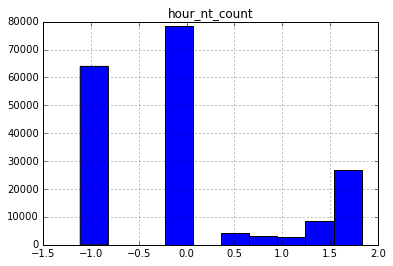

In [396]:
final_df.hist(['hour_nt_count'])

In [386]:
bins = np.arange(0, 1.1, 0.1)
quantised_df = final_df[CONTINUES_COLS].quantile(bins)
quantised_df.T

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
H0_to_2,-0.448710,-0.448710,-0.448710,-0.448710,-0.448710,-0.448710,-0.448710,-0.448710,-0.448710,2.035181,2.396315
H0_to_6,-0.604838,-0.604838,-0.604838,-0.604838,-0.604838,-0.604838,-0.604838,-0.604838,1.180924,1.952353,2.094786
H12_to_14,-0.625210,-0.625210,-0.625210,-0.625210,-0.625210,-0.625210,-0.625210,-0.625210,1.074800,1.925779,2.039467
H14_to_18,-0.741773,-0.741773,-0.741773,-0.741773,-0.741773,-0.741773,-0.741773,0.678477,0.678477,1.829491,1.956873
H18_to_20,-0.639443,-0.639443,-0.639443,-0.639443,-0.639443,-0.639443,-0.639443,1.034160,1.034160,1.905674,2.030619
H19_to_23,-0.765647,-0.765647,-0.765647,-0.765647,-0.765647,-0.765647,0.622964,0.622964,0.622964,1.802954,1.945943
H1_to_5,-0.462946,-0.462946,-0.462946,-0.462946,-0.462946,-0.462946,-0.462946,-0.462946,-0.462946,1.942230,2.360254
H20_to_22,-0.648185,-0.648185,-0.648185,-0.648185,-0.648185,-0.648185,-0.648185,0.995472,0.995472,1.884633,2.021087
H2_to_6,-0.502532,-0.502532,-0.502532,-0.502532,-0.502532,-0.502532,-0.502532,-0.502532,1.693881,2.072369,2.252311
H4_to_8,-0.630361,-0.630361,-0.630361,-0.630361,-0.630361,-0.630361,-0.630361,-0.630361,1.054124,1.924777,2.047944


In [152]:
# turn to dict
bucket_dic = dict()
for col in CONTINUES_COLS:
    bucket_dic[col] = quantised_df[col].unique().tolist()
import pickle
output = open('bucket.pkl', 'wb')
pickle.dump(bucket_dic, output)
output.close()

In [169]:
too_few_continues_features = []
for k,v in bucket_dic.iteritems():
    if len(v)<=2: 
        too_few_continues_features += [k]
too_few_continues_features

['Irritation_/_Fun_1',
 'geo_35_3_count',
 'geo_35_places_count',
 'geo_20_3_count',
 'Property_Industry_new',
 'Cards_RPG',
 'Tencent']

In [171]:
[CONTINUES_COLS.remove(col) for col in too_few_continues_features]

[None, None, None, None, None, None, None]

In [173]:
np.array(CONTINUES_COLS)

array(['H0_to_2', 'H0_to_6', 'H12_to_14', 'H14_to_18', 'H18_to_20',
       'H19_to_23', 'H1_to_5', 'H20_to_22', 'H2_to_6', 'H4_to_8',
       'H6_to_9', 'H8_to_10', 'H9_to_12', 'H9_to_14', 'app_active_count',
       'app_count', 'event_count', 'geo_20_2_count', 'geo_35_2_count',
       'holiday_51_count', 'hour_dt_count', 'hour_nt_count', '1_free',
       'Custom_label', 'Industry_tag', 'unknown'], 
      dtype='|S16')

In [153]:
np.array(CONTINUES_COLS)

array(['H0_to_2', 'H0_to_6', 'H12_to_14', 'H14_to_18', 'H18_to_20',
       'H19_to_23', 'H1_to_5', 'H20_to_22', 'H2_to_6', 'H4_to_8',
       'H6_to_9', 'H8_to_10', 'H9_to_12', 'H9_to_14', 'app_active_count',
       'app_count', 'event_count', 'geo_20_2_count', 'geo_20_3_count',
       'geo_35_2_count', 'geo_35_3_count', 'geo_35_places_count',
       'holiday_51_count', 'hour_dt_count', 'hour_nt_count', '1_free',
       'Cards_RPG', 'Custom_label', 'Industry_tag', 'Irritation_/_Fun_1',
       'Property_Industry_new', 'Tencent', 'unknown'], 
      dtype='|S21')

In [154]:
np.array(CATEGORICAL_COLS)

array(['5_1_day', '5_2_day', '5_3_day', '5_4_day', '5_5_day', '5_6_day',
       '5_7_day', 'H0_to_9', 'H18_to_23', 'H9_to_18', 'avg_events_perday',
       'geo_20_1_count', 'geo_20_1_label', 'geo_20_2_label',
       'geo_20_3_label', 'geo_20_places_count', 'geo_35_1_count',
       'geo_35_1_label', 'geo_35_2_label', 'geo_35_3_label',
       'geo_count_51holiday', 'geo_count_None_51holiday', 'group',
       'weekday_count', 'weekend_count', 'Personal_Effectiveness_1',
       'Property_Industry_2.0', 'Relatives_1', 'Services_1', 'game',
       'device_id', 'phone_brand', 'device_model', 'dt_count_51holiday',
       'dt_count_None_51holiday', 'nt_count_51holiday',
       'nt_count_None_51holiday'], 
      dtype='|S24')

## Split data into train eval and test 

In [159]:
test_df = final_df.loc[final_df.group.isnull(), :]
train_df = final_df.loc[~final_df.group.isnull(), :]
trai_ = train_df.iloc[:-20000, :]
eval_ = train_df.iloc[-20000:,:]
trai_.to_csv('train.csv', index=False)
eval_.to_csv('eval.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [160]:
print('train unique id {0}, test unique id {1}'.format(train_df.device_id.unique().shape, test_df.device_id.unique().shape))

train unique id (74645,), test unique id (112071,)


In [163]:
trai_ = train_df.iloc[:-20000, :]
eval_ = train_df.iloc[-20000:,:]
trai_.to_csv('train.csv', index=False)
eval_.to_csv('eval.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [162]:
train_df.head()


,5_1_day,5_2_day,5_3_day,5_4_day,5_5_day,5_6_day,5_7_day,H0_to_2,H0_to_6,H0_to_9,...,Tencent,game,unknown,device_id,phone_brand,device_model,dt_count_51holiday,dt_count_None_51holiday,nt_count_51holiday,nt_count_None_51holiday
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.448527,-0.602857,0.0,...,-0.2809,0.0,-0.592343,-1000369272589010951,vivo,Y17T,1,0,0,0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.448527,-0.602857,1.0,...,-0.2809,0.0,-0.592343,-1000572055892391496,OPPO,R819T,0,1,0,0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.448527,-0.602857,0.0,...,-0.2809,0.0,-0.592343,-1000643208750517791,金立,GN137,0,0,0,1
14,0.0,0.0,2.0,4.0,0.0,3.0,5.0,-0.448527,-0.602857,4.0,...,-0.2809,0.0,1.823143,-1001337759327042486,OPPO,A31,0,54,0,4
20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.448527,1.152066,1.0,...,-0.2809,0.0,-0.592343,-1001949518704267063,OPPO,R1,0,0,0,1


In [174]:
pkl_file = open('bucket.pkl', 'rb')
bucket_dic = pickle.load(pkl_file)
pkl_file.close()

In [230]:
for cols in CATEGORICAL_COLS:
    display(train_df.groupby(cols).size())

5_1_day
0.0     54008
1.0     14083
10.0        2
2.0      2576
3.0      2959
4.0       654
5.0       351
6.0       142
7.0        17
8.0        37
9.0        10
dtype: int64

5_2_day
0.0     53898
1.0     14091
10.0        4
12.0        1
2.0      2634
3.0      2951
4.0       665
5.0       396
6.0       151
7.0        10
8.0        32
9.0         6
dtype: int64

5_3_day
0.0     53242
1.0     14451
10.0        4
11.0        2
2.0      2702
3.0      3076
4.0       708
5.0       451
6.0       147
7.0        18
8.0        30
9.0         8
dtype: int64

5_4_day
0.0     53485
1.0     14228
11.0        3
2.0      2633
3.0      3100
4.0       711
5.0       450
6.0       177
7.0        12
8.0        34
9.0         6
dtype: int64

5_5_day
0.0     53165
1.0     14385
10.0        3
2.0      2698
3.0      3167
4.0       727
5.0       463
6.0       178
7.0        13
8.0        36
9.0         4
dtype: int64

5_6_day
0.0     53488
1.0     14089
10.0        3
2.0      2658
3.0      3235
4.0       725
5.0       434
6.0       147
7.0        24
8.0        32
9.0         4
dtype: int64

5_7_day
0.0     53955
1.0     13960
10.0        2
11.0        1
2.0      2677
3.0      2965
4.0       658
5.0       427
6.0       151
7.0         9
8.0        29
9.0         5
dtype: int64

H0_to_9
0.0     42139
1.0     22047
10.0       14
11.0        9
12.0        1
2.0      3146
3.0      4344
4.0      1362
5.0      1055
6.0       499
7.0        48
8.0       147
9.0        28
dtype: int64

H18_to_23
0.0     41294
1.0     22741
10.0       11
11.0        4
12.0        1
2.0      3206
3.0      4384
4.0      1515
5.0      1024
6.0       464
7.0        52
8.0       107
9.0        36
dtype: int64

H9_to_18
0.0     29394
1.0     31964
10.0       44
11.0       15
12.0        4
2.0      3433
3.0      4902
4.0      2011
5.0      1668
6.0       954
7.0       100
8.0       284
9.0        66
dtype: int64

avg_events_perday
0.0      1022
1.0     63039
10.0        6
2.0      4296
3.0      4643
4.0      1043
5.0       569
6.0       173
7.0        17
8.0        28
9.0         3
dtype: int64

geo_20_1_count
1.0     57768
10.0      127
11.0       71
12.0       15
2.0      3530
3.0      5697
4.0      2404
5.0      2456
6.0      1690
7.0       202
8.0       668
9.0       211
dtype: int64

geo_20_1_label
0.0      65129
1.0       7150
10.0         3
100.0        1
102.0        1
103.0        2
104.0        1
105.0        3
106.0        1
108.0        2
109.0        1
11.0        18
110.0        1
111.0        2
112.0        2
113.0        4
114.0        1
115.0        4
116.0        2
117.0        7
119.0        1
12.0         1
123.0        1
124.0        2
125.0        3
127.0        5
128.0        5
129.0        5
13.0         3
130.0        1
         ...  
666.0        1
667.0        1
67.0         1
68.0         2
69.0        14
7.0         11
71.0        16
72.0         2
73.0        11
74.0         3
75.0         3
76.0         1
78.0         1
80.0         3
81.0        10
82.0         5
83.0         2
84.0         1
86.0         6
87.0         6
89.0         2
9.0         21
90.0         3
92.0         3
93.0         1
94.0         4
95.0         1
97.0         2
98.0         2
99.0         1
dtype: int64

geo_20_2_label
-1.0     67110
0.0       5267
1.0       1482
10.0         2
100.0        1
103.0        1
105.0        1
106.0        2
107.0        1
108.0        1
109.0        1
11.0        36
112.0        3
115.0        1
118.0        1
120.0        1
123.0        1
124.0        2
126.0        1
129.0        1
13.0         1
131.0        2
133.0        2
136.0        1
137.0        1
139.0        1
14.0         5
140.0        3
142.0        1
146.0        4
         ...  
647.0        1
65.0         1
650.0        1
656.0        1
657.0        1
66.0         2
660.0        1
664.0        1
68.0         1
69.0         5
7.0          1
71.0         7
72.0         1
73.0         5
74.0         1
75.0         1
78.0         1
80.0         1
81.0         3
83.0         1
84.0         2
85.0         1
86.0         1
88.0         1
89.0         1
9.0          2
90.0         2
92.0         2
96.0         1
97.0         3
dtype: int64

geo_20_3_label
-1.0     74261
0.0        231
1.0         48
101.0        1
105.0        1
11.0        28
112.0        1
116.0        1
122.0        1
124.0        1
127.0        1
135.0        1
14.0         4
15.0         4
150.0        2
151.0        1
152.0        1
153.0        1
156.0        1
161.0        1
164.0        1
165.0        1
166.0        1
167.0        1
169.0        1
170.0        2
181.0        1
186.0        1
19.0         1
190.0        1
         ...  
581.0        1
584.0        1
587.0        1
59.0         1
598.0        1
6.0          7
604.0        1
611.0        1
614.0        1
63.0         1
631.0        1
632.0        1
635.0        1
638.0        1
64.0         1
644.0        1
648.0        1
65.0         2
654.0        1
69.0         1
70.0         1
71.0         1
73.0         1
77.0         1
79.0         1
8.0          1
87.0         1
9.0          2
91.0         1
92.0         1
dtype: int64

geo_20_places_count
1.0    74819
2.0       19
3.0        1
dtype: int64

geo_35_1_count
1.0     57747
10.0      131
11.0       71
12.0       15
2.0      3515
3.0      5686
4.0      2419
5.0      2460
6.0      1693
7.0       211
8.0       671
9.0       220
dtype: int64

geo_35_1_label
0.0      65114
1.0       9195
10.0         2
100.0        3
101.0        1
102.0        1
103.0        2
104.0        2
105.0        1
106.0        1
109.0        2
11.0        36
111.0        2
114.0        1
115.0        2
116.0        1
117.0        1
119.0        1
121.0        5
123.0        4
124.0        4
129.0        1
130.0        2
131.0        1
132.0        1
133.0        1
134.0        1
135.0        3
138.0        1
139.0        1
         ...  
57.0         2
58.0         1
60.0         1
62.0         1
63.0         2
64.0         1
66.0         3
67.0         1
7.0         10
72.0         1
74.0         7
75.0         1
76.0         5
77.0         1
8.0          1
80.0         1
81.0         2
83.0         1
85.0         1
86.0         4
88.0         2
89.0         1
9.0          1
90.0         2
91.0         1
92.0         1
93.0         1
95.0         5
96.0         3
97.0         3
dtype: int64

geo_35_2_label
-1.0     67351
0.0       5461
1.0       1813
104.0        4
107.0        1
108.0        1
11.0        10
110.0        1
112.0        1
113.0        1
117.0        1
118.0        1
119.0        1
12.0         1
120.0        1
122.0        1
125.0        1
126.0        1
127.0        1
128.0        1
132.0        1
134.0        1
135.0        1
136.0        1
137.0        2
14.0         7
141.0        1
142.0        1
143.0        1
148.0        1
         ...  
41.0         1
43.0         2
46.0         1
47.0         1
49.0         1
5.0          7
53.0         5
58.0         1
59.0         1
6.0          1
65.0         1
66.0         1
69.0         1
7.0          2
73.0         1
74.0         4
76.0         2
78.0         1
8.0          1
81.0         1
82.0         1
84.0         1
85.0         1
86.0         3
88.0         1
89.0         1
90.0         1
94.0         2
98.0         1
99.0         2
dtype: int64

geo_35_3_label
-1.0     74670
0.0         73
1.0         24
104.0        1
11.0         1
121.0        1
123.0        1
126.0        1
127.0        1
13.0         1
134.0        1
136.0        1
14.0         1
168.0        1
18.0         3
188.0        1
194.0        1
2.0          2
20.0         1
209.0        1
21.0         1
211.0        1
214.0        1
218.0        1
22.0         1
23.0         1
28.0         1
3.0         28
32.0         1
33.0         1
34.0         1
37.0         1
38.0         1
40.0         1
50.0         1
53.0         1
61.0         1
68.0         1
7.0          1
79.0         1
83.0         1
84.0         1
86.0         1
87.0         1
88.0         1
dtype: int64

geo_count_51holiday
0.0    43507
1.0    31330
2.0        2
dtype: int64

geo_count_None_51holiday
0.0    16041
1.0    58787
2.0       10
3.0        1
dtype: int64

group
F23-      5063
F24-26    4202
F27-28    3121
F29-32    4639
F33-42    5576
F43+      4204
M22-      7514
M23-26    9629
M27-28    5463
M29-31    7336
M32-38    9492
M39+      8600
dtype: int64

weekday_count
0.0     24323
1.0     36189
10.0       56
11.0       22
12.0        5
2.0      3559
3.0      4979
4.0      2030
5.0      1928
6.0      1118
7.0       138
8.0       386
9.0       106
dtype: int64

weekend_count
0.0     33821
1.0     28254
10.0       35
11.0        7
12.0        2
2.0      3545
3.0      4925
4.0      1762
5.0      1442
6.0       734
7.0        67
8.0       193
9.0        52
dtype: int64

Personal_Effectiveness_1
0.0    61860
1.0    12165
2.0      802
3.0       12
dtype: int64

Property_Industry_2.0
0.0    53592
1.0     7106
2.0     6226
3.0     7639
4.0      264
5.0       12
dtype: int64

Relatives_1
0.0    58721
1.0    15409
2.0      701
3.0        8
dtype: int64

Services_1
0.0    56581
1.0    10907
2.0     5092
3.0     2245
4.0       14
dtype: int64

game
0.0    72248
1.0     2586
2.0        5
dtype: int64

device_id
-1000369272589010951    1
-1000572055892391496    1
-1000643208750517791    1
-1001337759327042486    1
-1001949518704267063    1
-1002079624347534227    1
-1002595372059179606    1
-1002733576670974332    1
-1002969456091702673    1
-1003040252653187383    1
-1004340479133163587    1
-1004665990003063053    1
-1004900862756909520    1
-1005411102947247412    1
-1006117296310180539    1
-1006244095847674899    1
-1006357788560227421    1
-1006562022942738675    1
-1006944931823856367    1
-1007249684892521754    1
-1007720066489438583    1
-1008024264391409607    1
-1008055017361339310    1
-1008056923666884215    1
-1008484851265061759    1
-1008485807774291846    1
-1009019158234128491    1
-1009806765098772259    1
-1010220048780328322    1
-1010331399860272993    1
                       ..
993894748934539938      1
993953247600713667      1
994636686117727811      1
99479029389286800       1
994957985493748350      1
996163203858940369      1
996188566670327147      1
99

phone_brand
E派          10
HTC       1015
LG         333
LOGO        19
Lovme       15
MIL          1
OPPO      5802
PPTV         3
SUGAR        6
TCL        222
ZOYE         1
ZUK         56
vivo      5658
一加         174
三星       13706
世纪天元         1
中兴         861
中国移动       275
丰米           2
乐视         760
乡米           4
亚马逊          1
亿通          29
优米         192
优语           1
优购          24
先锋           5
凯利通          1
努比亚        484
华为       13001
         ...  
聆韵          21
联想        2695
至尊宝         12
艾优尼         40
蓝魔           3
虾米           3
西米           7
西门子          1
语信         170
诺亚信         15
诺基亚         25
谷歌           7
贝尔丰         23
邦华          12
酷比          67
酷比魔方        64
酷派        3349
酷珀          21
金星数码         3
金立        1124
锤子         191
长虹           7
青橙          12
青葱           4
飞利浦          1
飞秒           1
首云           3
魅族        4710
鲜米           1
黑米          35
dtype: int64

device_model
1100                 8
1105                57
1107               124
2                   18
201                 12
2016版 Galaxy A5     13
2016版 Galaxy A7     24
2016版 Galaxy A9     36
210R                10
3                   65
3000                 2
3005                 5
3007                49
3S                  12
5200S                5
5216D                5
5216s                2
5217                 8
5218S                3
5219                 6
5261                 2
5263                16
5263S                1
5310                 1
5311                 6
5313S                2
5316                13
5360                12
5832                 2
5860S                3
                  ... 
远航3                  1
醉享                   1
金钢                  21
锋尚                 101
锋尚2                  6
锋尚Air                1
锋尚Max               12
锋尚Pro               45
锋尚mini               1
雷霆战机                 5
青春版                115
青漾3                  

dt_count_51holiday
0      51908
1      11230
10       356
100        4
102        5
103        5
104        3
105        2
106        2
107        5
108        5
109        5
11       306
110        2
111        5
112        4
114        3
115        2
116        4
117        2
118        4
119        1
12       244
120        1
121        3
122        1
123        3
124        1
125        1
126        4
       ...  
73        11
74         9
743        1
75         8
76         9
77         4
78        10
79        11
8        422
80         6
81         5
82         8
83         7
84         5
85         6
86         6
87        10
88         6
89         6
9        382
90         8
91         8
92        10
93         7
94         4
95         4
96        12
97         2
98         2
99         7
dtype: int64

dt_count_None_51holiday
0      42980
1      17538
10       410
100       12
101       10
102       12
103        5
104        5
105       12
106       11
107       14
108       19
109        8
11       347
110        6
111        9
112       10
113        6
114        9
115       12
116        7
117        6
118        5
119        8
12       322
120       11
121       10
122        5
123        4
124        6
       ...  
73        21
74        23
75        36
76        16
77        21
78        14
79        26
8        509
80        15
81        15
82        14
83        10
84        26
85        12
858        1
86        23
87        13
88        16
89        11
9        423
90         4
91        15
92         5
93        15
94         7
95         5
96        18
97        14
98         8
99         9
dtype: int64

nt_count_51holiday
0      56623
1       8504
10       287
100        3
101        2
102        1
103        1
104        5
105        1
106        2
107        2
108        2
109        2
11       249
110        5
111        4
112        3
113        3
116        5
117        5
118        1
119        1
12       230
120        1
122        1
123        1
125        2
128        3
129        1
13       205
       ...  
70         8
71         7
72         7
73         3
74         3
75         2
76         5
77         5
78         9
79         4
8        371
80         3
81         4
82         4
83         3
84         2
85         2
86         6
87         6
88         4
89         3
9        301
90         8
91         3
92         2
94         2
95         2
97         2
98         1
99         2
dtype: int64

nt_count_None_51holiday
0       42514
1       17729
10        434
100         7
101        13
102        11
103        12
104        13
105         9
106         4
107         8
108         8
109         9
11        363
110        10
111         8
112         6
1125        1
113         5
114         4
1140        1
115         5
116         5
117         7
118        10
119         7
12        345
120         5
121         7
122         7
        ...  
75         18
76         13
77         23
78         21
782         1
79         14
8         563
80         18
803         1
81          9
82         14
83         19
84         14
85         22
86          9
87         15
88         15
888         1
89         17
9         447
90         11
91         15
92          7
93         13
94         10
95          7
96          8
97          9
98         10
99         10
dtype: int64

In [224]:
train_df.hist('5_1_day')

ValueError: num must be 1 <= num <= 0, not 1

In [176]:
for col in CONTINUES_COLS:
    try:
        print bucket_dic[col]
    except:
        pass

[-0.4485267993085881, 2.0201186446830066, 2.410852226571987]
[-0.6028565560311197, 1.1520660539159056, 1.9627051663626993, 2.1323424221502036]
[-0.6236286351216195, 1.0532499861840467, 1.9357933610126299, 2.0679106192666312]
[-0.7370965401651973, 0.6503000820073345, 1.8446446610229952, 2.0145063286607856]
[-0.6376190949467391, 1.0119882823990134, 1.9159939544959275, 2.0619126973132205]
[-0.7602320411816341, 0.5943820771216765, 1.8172509921474846, 2.010115508615163]
[-0.4626535082554571, -0.46265350825545704, 1.923737406690307, 2.3793216350172175]
[-0.646147001699393, -0.6461470016993931, 0.972216931970435, 1.8945068574688937, 2.054702174529223]
[-0.5020042494688338, 1.673011023555909, 2.0711632559419093, 2.2742082735898124]
[-0.6282561395040802, 1.0279070429981536, 1.9361890333990632, 2.0830043920290984]
[-0.6622765127678627, 0.8879676830489253, 1.8982683789203696, 2.0468315347059445]
[-0.636418434529862, 0.9898722104082791, 1.9037977476013297, 2.0584257292187638]
[-0.7069325401760982,

In [178]:
import tensorflow as tf

In [179]:
CONTINUES_COLS

['H0_to_2',
 'H0_to_6',
 'H12_to_14',
 'H14_to_18',
 'H18_to_20',
 'H19_to_23',
 'H1_to_5',
 'H20_to_22',
 'H2_to_6',
 'H4_to_8',
 'H6_to_9',
 'H8_to_10',
 'H9_to_12',
 'H9_to_14',
 'app_active_count',
 'app_count',
 'event_count',
 'geo_20_2_count',
 'geo_35_2_count',
 'holiday_51_count',
 'hour_dt_count',
 'hour_nt_count',
 '1_free',
 'Custom_label',
 'Industry_tag',
 'unknown']

In [183]:
for continues_tensor_layer in continues_base_cols:
    print bucket_dic[continues_tensor_layer.name]

[-0.4485267993085881, 2.0201186446830066, 2.410852226571987]
[-0.6028565560311197, 1.1520660539159056, 1.9627051663626993, 2.1323424221502036]
[-0.6236286351216195, 1.0532499861840467, 1.9357933610126299, 2.0679106192666312]
[-0.7370965401651973, 0.6503000820073345, 1.8446446610229952, 2.0145063286607856]
[-0.6376190949467391, 1.0119882823990134, 1.9159939544959275, 2.0619126973132205]
[-0.7602320411816341, 0.5943820771216765, 1.8172509921474846, 2.010115508615163]
[-0.4626535082554571, -0.46265350825545704, 1.923737406690307, 2.3793216350172175]
[-0.646147001699393, -0.6461470016993931, 0.972216931970435, 1.8945068574688937, 2.054702174529223]
[-0.5020042494688338, 1.673011023555909, 2.0711632559419093, 2.2742082735898124]
[-0.6282561395040802, 1.0279070429981536, 1.9361890333990632, 2.0830043920290984]
[-0.6622765127678627, 0.8879676830489253, 1.8982683789203696, 2.0468315347059445]
[-0.636418434529862, 0.9898722104082791, 1.9037977476013297, 2.0584257292187638]
[-0.7069325401760982,

In [186]:
for continues_tensor_layer in continues_base_cols:
#continues_tensor_layer = continues_base_cols[0]
    #a = tf.contrib.layers.bucketized_column(continues_tensor_layer, boundaries=bucket_dic[continues_tensor_layer.name])
    print continues_tensor_layer.name

H0_to_2
H0_to_6
H12_to_14
H14_to_18
H18_to_20
H19_to_23
H1_to_5
H20_to_22
H2_to_6
H4_to_8
H6_to_9
H8_to_10
H9_to_12
H9_to_14
app_active_count
app_count
event_count
geo_20_2_count
geo_35_2_count
holiday_51_count
hour_dt_count
hour_nt_count
1_free
Custom_label
Industry_tag
unknown


In [187]:
bucket_dic['H20_to_22'] # causing problem!

[-0.646147001699393,
 -0.6461470016993931,
 0.972216931970435,
 1.8945068574688937,
 2.054702174529223]

In [188]:
bucket_dic['H20_to_22'] = [-0.646147001699393,
 -0.6451470016993931,
 0.972216931970435,
 1.8945068574688937,
 2.054702174529223]

In [190]:
output = open('bucket.pkl', 'wb')
pickle.dump(bucket_dic, output)
output.close()

In [192]:

continues_base_cols = [tf.contrib.layers.real_valued_column(name) for name in CONTINUES_COLS]

bucketized_continues_columns = [tf.contrib.layers.bucketized_column(continues_tensor_layer, 
                                                                    boundaries=bucket_dic[continues_tensor_layer.name]) 
                                for continues_tensor_layer in continues_base_cols]

In [204]:
categorical_base_cols = [tf.contrib.layers.sparse_column_with_hash_bucket(column_name=name, hash_bucket_size=1e3) for name in CATEGORICAL_COLS]
categorical_embed_base_cols = [tf.contrib.layers.embedding_column(cate_layer, dimension=30) for cate_layer in categorical_base_cols]

In [197]:
for c1 in CROSS_BASE_COL1:
    print c1 
    for c2 in CROSS_BASE_COL2:
        print

for layer in cross_base_columns:
    print layer.name

('phone_brand', 'geo_20_1_label')
('phone_brand', 'geo_count_51holiday')
('phone_brand', 'Personal_Effectiveness_1')
('phone_brand', 'Relatives_1')
('phone_brand', 'H9_to_18')
('phone_brand', '5_4_day')
('phone_brand', '5_5_day')
('phone_brand', '5_6_day')
('phone_brand', '5_7_day')
('phone_brand', 'weekend_count')
('device_model', 'geo_20_1_label')
('device_model', 'geo_count_51holiday')
('device_model', 'Personal_Effectiveness_1')
('device_model', 'Relatives_1')
('device_model', 'H9_to_18')
('device_model', '5_4_day')
('device_model', '5_5_day')
('device_model', '5_6_day')
('device_model', '5_7_day')
('device_model', 'weekend_count')
H0_to_2_BUCKETIZED
H0_to_6_BUCKETIZED
H12_to_14_BUCKETIZED
H14_to_18_BUCKETIZED
H18_to_20_BUCKETIZED
H19_to_23_BUCKETIZED
H1_to_5_BUCKETIZED
H20_to_22_BUCKETIZED
H2_to_6_BUCKETIZED
H4_to_8_BUCKETIZED
H6_to_9_BUCKETIZED
H8_to_10_BUCKETIZED
H9_to_12_BUCKETIZED
H9_to_14_BUCKETIZED
app_active_count_BUCKETIZED
app_count_BUCKETIZED
event_count_BUCKETIZED
geo_2

In [214]:
CROSS_BASE_COL1 = ['phone_brand', 'device_model']
CROSS_BASE_COL2 = ['geo_20_1_label', 'geo_count_51holiday', 'Personal_Effectiveness_1', 'Relatives_1', 'H9_to_18', '5_4_day', '5_5_day', '5_6_day','5_7_day', 'weekend_count']
CROSS_BASE_COL3 = ['weekday_count', 'H0_to_9', '5_1_day', '5_2_day', '5_3_day', 'geo_count_None_51holiday']
def _cross_columns_2d(cross_base_cols1, cross_base_cols2, cross_base_columns):
	crossed_columns = []
	for c1 in cross_base_cols1:
		c1_layer = next((layer for layer in cross_base_columns
			if layer.name == c1 or layer.name == c1+'_BUCKETIZED'), None)
		for c2 in cross_base_cols2:
			c2_layer = next((layer for layer in cross_base_columns
			if layer.name == c2  or layer.name == c2+'_BUCKETIZED' ), None)
			crossed_columns +=[tf.contrib.layers.crossed_column([c1_layer, c2_layer], hash_bucket_size=int(1e5))] #flaw
	return crossed_columns

cross_base_columns =  categorical_base_cols +bucketized_continues_columns
crossed_columns, crossed_columns_2d = [], []
crossed_columns += _cross_columns_2d(CROSS_BASE_COL1, CROSS_BASE_COL2, cross_base_columns)
crossed_columns += _cross_columns_2d(CROSS_BASE_COL2, CROSS_BASE_COL3, cross_base_columns)
crossed_columns += _cross_columns_2d(CROSS_BASE_COL1, CROSS_BASE_COL3, cross_base_columns)

crossed_names = [(crossed.name.split('_X_'), crossed) for crossed in crossed_columns]

In [217]:
len(crossed_names)

92

In [216]:
for col in CROSS_BASE_COL1 + CROSS_BASE_COL2 + CROSS_BASE_COL3:
    for names, crossed in crossed_names:
        if col not in names:
            print names, col

['device_model', 'geo_20_1_label'] phone_brand
['device_model', 'geo_count_51holiday'] phone_brand
['Personal_Effectiveness_1', 'device_model'] phone_brand
['Relatives_1', 'device_model'] phone_brand
['H9_to_18', 'device_model'] phone_brand
['5_4_day', 'device_model'] phone_brand
['5_5_day', 'device_model'] phone_brand
['5_6_day', 'device_model'] phone_brand
['5_7_day', 'device_model'] phone_brand
['device_model', 'weekend_count'] phone_brand
['geo_20_1_label', 'weekday_count'] phone_brand
['H0_to_9', 'geo_20_1_label'] phone_brand
['5_1_day', 'geo_20_1_label'] phone_brand
['5_2_day', 'geo_20_1_label'] phone_brand
['5_3_day', 'geo_20_1_label'] phone_brand
['geo_20_1_label', 'geo_count_None_51holiday'] phone_brand
['geo_count_51holiday', 'weekday_count'] phone_brand
['H0_to_9', 'geo_count_51holiday'] phone_brand
['5_1_day', 'geo_count_51holiday'] phone_brand
['5_2_day', 'geo_count_51holiday'] phone_brand
['5_3_day', 'geo_count_51holiday'] phone_brand
['geo_count_51holiday', 'geo_count_No

In [212]:
crossed_names = [(crossed.name.split('_X_'), crossed) for crossed in crossed_columns]

In [213]:
for name, _ in crossed_names:
    print name

['geo_20_1_label', 'phone_brand']


In [206]:
crossed_columns

[_CrossedColumn(columns=(_SparseColumn(column_name='geo_20_1_label', is_integerized=False, bucket_size=1000.0, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='phone_brand', is_integerized=False, bucket_size=1000.0, lookup_config=None, combiner='sum', dtype=tf.string)), hash_bucket_size=100000, combiner='sum'),
 _CrossedColumn(columns=(_SparseColumn(column_name='geo_count_51holiday', is_integerized=False, bucket_size=1000.0, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='phone_brand', is_integerized=False, bucket_size=1000.0, lookup_config=None, combiner='sum', dtype=tf.string)), hash_bucket_size=100000, combiner='sum'),
 _CrossedColumn(columns=(_SparseColumn(column_name='Personal_Effectiveness_1', is_integerized=False, bucket_size=1000.0, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumn(column_name='phone_brand', is_integerized=False, bucket_size=1000.0, lookup_config=None, combiner='sum', dtype=tf.st

In [196]:
_cross_columns_2d(CROSS_BASE_COL1, CROSS_BASE_COL2, cross_base_columns)

TypeError: columns should be a set of _SparseColumn, _CrossedColumn, or _BucketizedColumn. Column is None